## Семинар 3 "Определение ключевых точек лица"

ФИО: Петряйкин Федор Алексеевич

## Задание

Используя датасет из архива решите задачу регрессии для поиска 68-ми ключевых точек лица. 

Для обучения и валидации используйте изображения и разметку из папок train и test соответственно.

Попробуйте сети глубины 1 и 2 и разные активации (ELU, RELU и sigmoid).
Для каждой архитектуры постройте графики для функции потерь на train/test

Image name: 109.jpeg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 7. 41.]
 [ 8. 51.]
 [10. 60.]
 [13. 70.]]


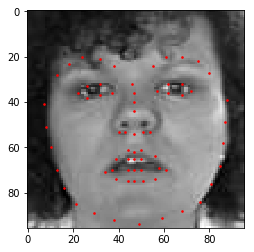

In [2]:
%matplotlib inline
from __future__ import print_function, division
import os
import torch
import sys
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn import MSELoss, Sequential, Linear, Sigmoid, Tanh, ReLU, ELU
from torch.autograd import Variable
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

landmarks_frame = pd.read_csv('dataset/train/face_landmarks.csv')

n = 100
img_name = landmarks_frame.ix[n, 0]
landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype('float')
landmarks = landmarks.reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='red', cmap='rgb')
    plt.pause(0.001)  

plt.figure()
show_landmarks(io.imread(os.path.join('dataset/train/', img_name)),
               landmarks)
plt.show()

In [3]:
def show_landmarks_batch(sample_batch, y_pred=None):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batch['image'], sample_batch['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    print(images_batch.numpy().shape)
    plt.imshow(grid.numpy().transpose(1,0,2).reshape(im_size, -1), cmap="gray")

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r', label='Real')

    if type(y_pred) != type(None):
        for i in range(batch_size):
            plt.scatter(y_pred[i, :, 0] + i * im_size,
                        y_pred[i, :, 1],
                        s=10, marker='.', c='b',  label='Prediction')
        plt.title('Batch from dataloader')
    plt.legend()

In [4]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix().astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [5]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [6]:
train_dataset = FaceLandmarksDataset(csv_file='dataset/train/face_landmarks.csv',
                                     root_dir='dataset/train',
                                     transform=ToTensor()
                                     )

test_dataset = FaceLandmarksDataset(csv_file='dataset/test/face_landmarks.csv',
                                     root_dir='dataset/test',
                                     transform=ToTensor()
                                     )

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=64,
                        shuffle=True, num_workers=0)

test_dataloader = DataLoader(test_dataset, batch_size=64,
                        shuffle=True, num_workers=0)

In [8]:
from torch.optim.lr_scheduler import StepLR

dtype=torch.cuda.FloatTensor

def train(network, epochs, learning_rate, ravel=True, loss=MSELoss(), optim=torch.optim.Adam,
          step_size=10, gamma=0.5):
    train_loss_epochs = []
    test_loss_epochs = []
    optimizer = optim(network.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size, gamma)
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for sample in train_dataloader:
                X = sample['image']
                if ravel:
                    X = Variable(X.view(X.shape[0], -1)).type(dtype).cuda()
                else:
                    X = Variable(X.unsqueeze(1)).type(dtype).cuda()
                
                y = sample['landmarks']
                if ravel:
                    y = Variable(y.view(y.shape[0], -1)).type(dtype).cuda()
                else:
                    y = Variable(y.unsqueeze(1)).type(dtype).cuda()
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                optimizer.zero_grad()
                loss_batch.backward()
                optimizer.step()
            scheduler.step()
  
            train_loss_epochs.append(np.mean(losses))
            if len(train_loss_epochs) > 10:
                del train_loss_epochs[0]
                
            losses = []    
            for sample in test_dataloader:
                X = sample['image']
                if ravel:
                    X = Variable(X.view(X.shape[0], -1)).type(dtype).cuda()
                else:
                    X = Variable(X.unsqueeze(1)).type(dtype).cuda()
                y = sample['landmarks']
                if ravel:
                    y = Variable(y.view(y.shape[0], -1)).type(dtype).cuda()
                else:
                    y = Variable(y.unsqueeze(1)).type(dtype).cuda()
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                
            test_loss_epochs.append(np.mean(losses))
            if len(test_loss_epochs) > 10:
                del test_loss_epochs[0]
                
            sys.stdout.write('\rEpoch {0}... (Train/Test) MSE: {1:.3f}/{2:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.plot(train_loss_epochs[1:], label='Train')
    plt.plot(test_loss_epochs[1:], label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

In [8]:
networkTanh = Sequential(Linear(1 * 96 * 96, 200), Tanh(),
                         Linear(200, 2 * 68))
networkSigmoid = Sequential(Linear(1 * 96 * 96, 200), Sigmoid(),
                            Linear(200, 2 * 68))
networkReLU = Sequential(Linear(1 * 96 * 96, 200), ReLU(),
                         Linear(200, 2 * 68))
networkELU = Sequential(Linear(1 * 96 * 96, 200), ELU(),
                        Linear(200, 2 * 68))

networks = [networkTanh, networkSigmoid, networkReLU, networkELU]

Sequential(
  (0): Linear(in_features=9216, out_features=200, bias=True)
  (1): Tanh()
  (2): Linear(in_features=200, out_features=136, bias=True)
)
Epoch 14... (Train/Test) MSE: 17.456/18.564150

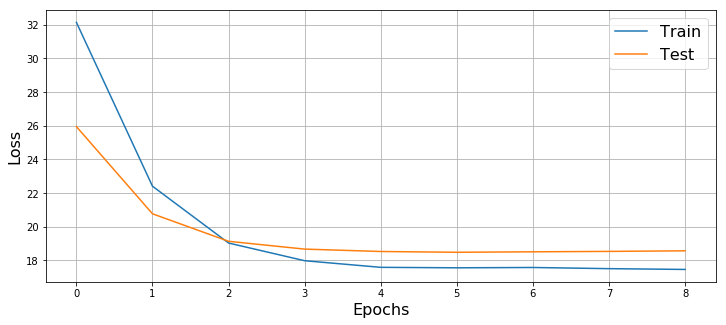

Sequential(
  (0): Linear(in_features=9216, out_features=200, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=200, out_features=136, bias=True)
)
Epoch 29... (Train/Test) MSE: 17.488/18.482319

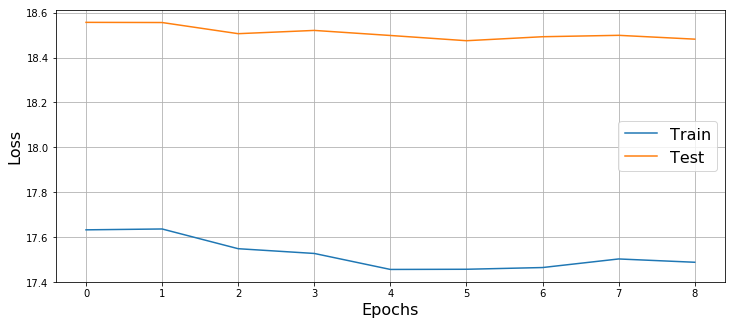

Sequential(
  (0): Linear(in_features=9216, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=136, bias=True)
)
Epoch 10... (Train/Test) MSE: 3184.411/3165.825

Exception ignored in: <bound method Image.__del__ of <PIL.JpegImagePlugin.JpegImageFile image mode=L size=96x96 at 0x21596C87D68>>
Traceback (most recent call last):
  File "e:\c_folders\users\fen\anaconda2\envs\py36\lib\site-packages\PIL\Image.py", line 586, in __del__
    def __del__(self):
KeyboardInterrupt


Epoch 14... (Train/Test) MSE: 3145.147/3126.193

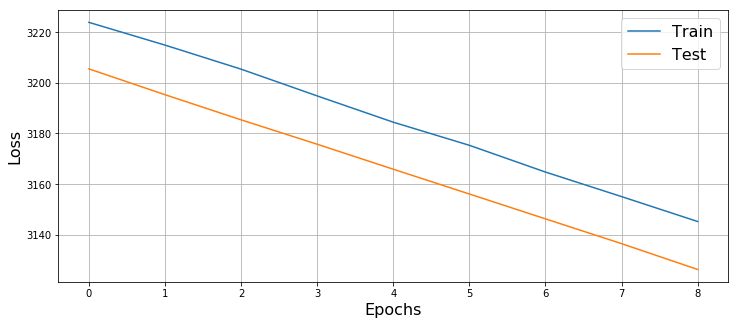

Sequential(
  (0): Linear(in_features=9216, out_features=200, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=200, out_features=136, bias=True)
)
Epoch 25... (Train/Test) MSE: 17.559/18.497257

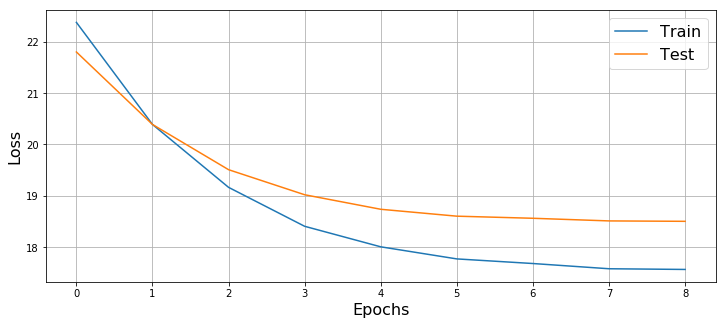

In [9]:
for n in networks:
    print (n)
    train(n.cuda(), 30, 1e-3)
    plt.show()

In [9]:
import torch
import torch.nn as nn

class SqueezeModule(nn.Module):
    def __init__(self):
        super(SqueezeModule, self).__init__()
    
    def forward(self, x):
        return x.squeeze()
    
class VerboseModule(nn.Module):
    def __init__(self):
        super(VerboseModule, self).__init__()
    
    def forward(self, x):
        print (x.shape)
        return x

Epoch 29... (Train/Test) MSE: 3.494/5.797605

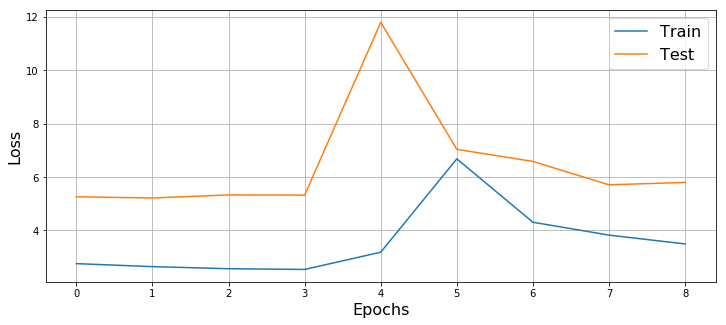

In [10]:
network = Sequential(nn.Conv2d(1, 16, 3), ReLU(), nn.MaxPool2d(2),
                     nn.Conv2d(16, 64, 3), ReLU(), nn.MaxPool2d(2), 
                     nn.Conv2d(64, 22*22, 22), SqueezeModule(),
                     nn.Linear(22*22, 200), ReLU(),
                     nn.BatchNorm1d(200), nn.Linear(200, 2*68))
train(network.cuda(), 30, 1e-2, ravel=False)

(2, 96, 96)


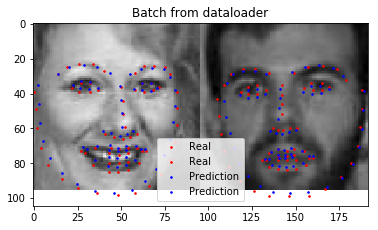

In [16]:
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=0)
batch = next(iter(test_dataloader))
images_batch = batch['image']
x = Variable(images_batch.unsqueeze(1).type(dtype)).cuda()
y_pred = network.cuda()(x)
y = Variable(batch['landmarks'].unsqueeze(1).type(dtype)).cuda()
y_pred = y_pred.view(-1, 68, 2)
y_pred = y_pred.data.cpu().numpy()
show_landmarks_batch(batch, y_pred)